# Analyze results

### Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgba
import seaborn as sns

from scipy import ndimage

import geopandas as gpd

In [3]:
import pandas as pd

In [4]:
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow import keras

In [5]:
#from xgboost import XGBClassifier

In [6]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

### Data path

In [7]:
data_path = "/content/drive/MyDrive/PROJECT ML/ProcessedData"
plot_path = "/content/drive/MyDrive/PROJECT ML/plots"
output_path = "/content/drive/MyDrive/PROJECT ML/Outputs"

In [8]:
def load_array_from_npy(name, path=data_path):
    return np.load(os.path.join(path, f"{name}.npy"))

In [9]:
def save_array_as_npy(array, name, path=output_path):
    output_fn = os.path.join(path, f"{name}.npy")

    print(f"shape of {name}", array.shape)
    print("saved to", output_fn)

    np.save(output_fn, array)

### Loading shape mask and flood inventory

In [10]:
elevation = load_array_from_npy("elevation")
shape_mask = (elevation < 0)

In [11]:
df = pd.read_csv(os.path.join(data_path, "flood_idx.csv"))
len(df)

252

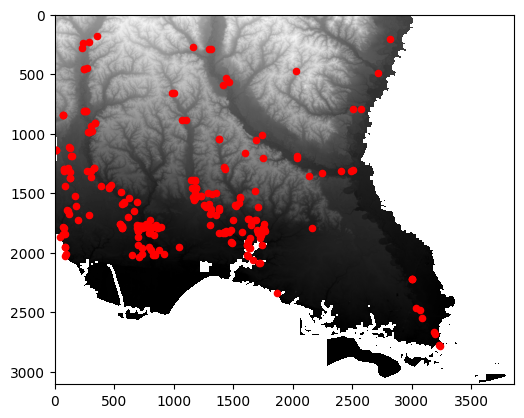

In [12]:
masked_elevation = np.ma.array(elevation, mask = shape_mask)
plt.imshow(masked_elevation, cmap='gray')
plt.scatter(df.to_numpy()[:,1], df.to_numpy()[:,0],
            c='r', s=20)
plt.show()

### Utils

In [37]:
def plot_result_map(result_map, title, colorbar_label=None,
                    figsize=(8, 6), filename=None,
                    cmap='viridis',
                    scatter_df=True, color='r'):
    fig, ax = plt.subplots(figsize=figsize)

    masked_result_map = np.ma.array(result_map, mask = shape_mask)
    img = ax.imshow(masked_result_map, cmap=cmap)
    cbar = plt.colorbar(img, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('Probability of flooding')

    if scatter_df:
        ax.scatter(df.to_numpy()[:,1],
                    df.to_numpy()[:,0],
                    c=color, s=20)

    plt.title(title)

    if filename is not None:
        plt.savefig(filename)
    plt.show()

## Machine Learning result maps

In [15]:
result_maps = {}

### Neural Network

In [34]:
#plot_result_map(result_map,
#                title='Neural Network prediction',
#                colorbar_label='Probability of flooding')

### XGBoost

In [24]:
params = [(2,6,100),
          (4,6,100),
          (4,4,100)]

for boost_param, max_depth, scale_pos_weight in params:

    fn = f"xgboost_boost_{boost_param}_max_depth_{max_depth}_scale_pos_weight_{scale_pos_weight}"
    xgboost_map = load_array_from_npy(fn, output_path).astype(bool)
    result_maps[fn] = xgboost_map

In [25]:
xgboost_map.dtype

dtype('bool')

xgboost_boost_4_max_depth_4_scale_pos_weight_100


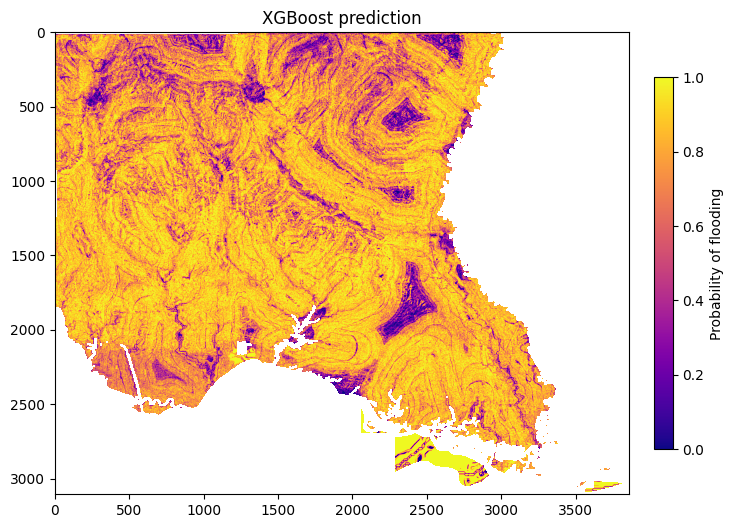

In [26]:
print(fn)
plot_result_map(xgboost_map,
                title='XGBoost prediction',
                colorbar_label='Probability of flooding',
                cmap='plasma',
                scatter_df=False)

### Random forest

In [27]:
# Selected params
params = [(8,5),
          (8,6)]

for boost_param, max_depth in params:

    fn = f"random_forest_boost_{boost_param}_max_depth_{max_depth}"
    random_forest_map = load_array_from_npy(fn, output_path).astype(bool)
    result_maps[fn] = random_forest_map

In [28]:
random_forest_map.dtype

dtype('bool')

random_forest_boost_8_max_depth_6


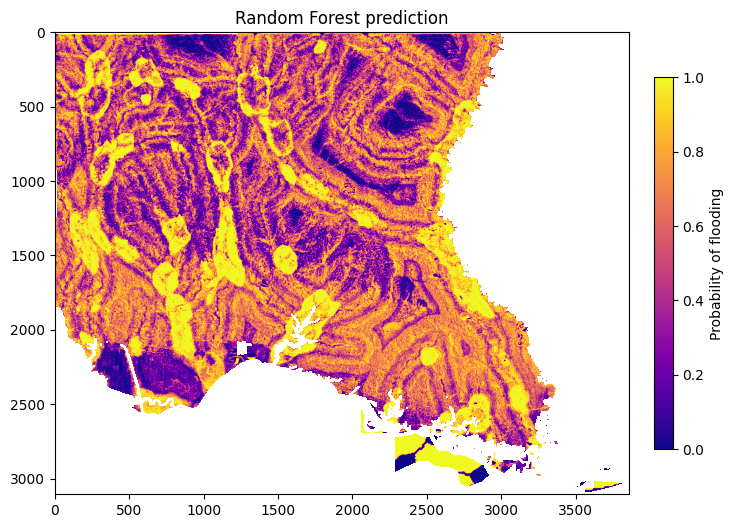

In [29]:
print(fn)
plot_result_map(random_forest_map,
                title='Random Forest prediction',
                colorbar_label='Probability of flooding',
                cmap='plasma',
                scatter_df=False)

### Gaussian Mixture Model

In [16]:
params = [10, 12]


for boost_param in params:

    fn = f"gaussian_mixture_boost_{boost_param}"
    gaussian_map = load_array_from_npy(fn, output_path).astype(bool)
    result_maps[fn] = gaussian_map


gaussian_mixture_boost_12


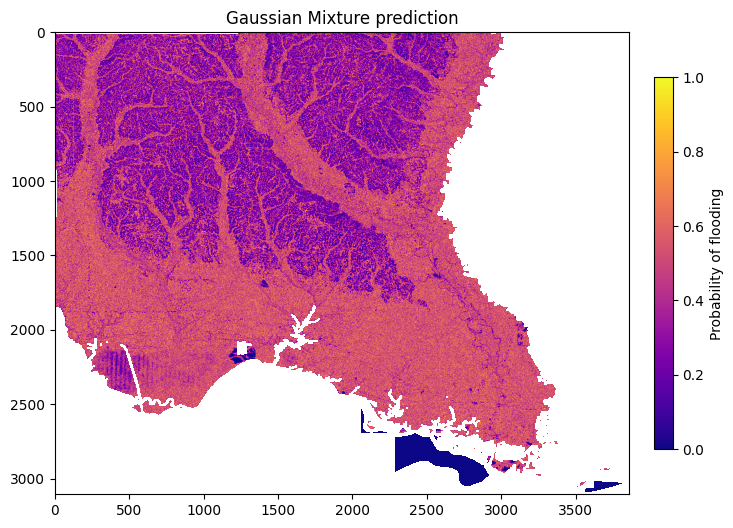

In [17]:
print(fn)
plot_result_map(gaussian_map,
                title='Gaussian Mixture prediction',
                colorbar_label='Probability of flooding',
                cmap='plasma',
                scatter_df=False)

The map is very noisy, let's filter it

### Filter the result maps

In [19]:
%%time
from scipy.signal import medfilt

med_result_map = medfilt(gaussian_map.astype(float), 9)

CPU times: user 6.36 s, sys: 43.6 ms, total: 6.4 s
Wall time: 7.2 s


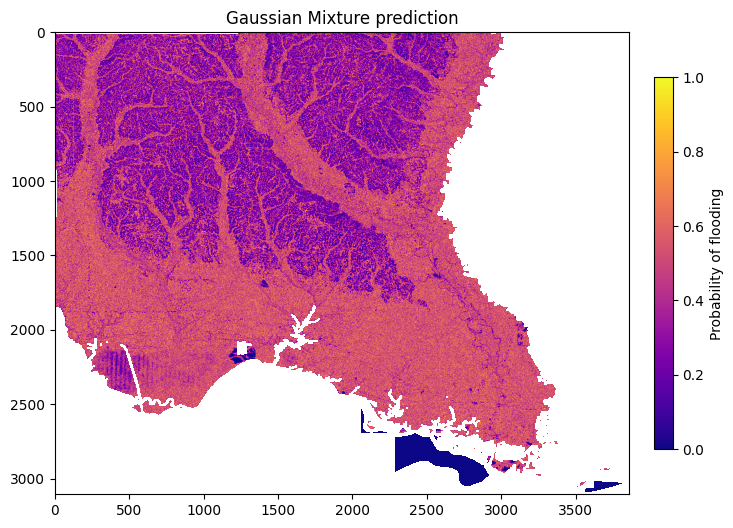

In [20]:
plot_result_map(gaussian_map,
                title='Gaussian Mixture prediction',
                #colorbar_label='Probability of flooding',
                #filename=os.path.join(plot_path, 'gaussian_map.png'),
                cmap='plasma',
                scatter_df=False)

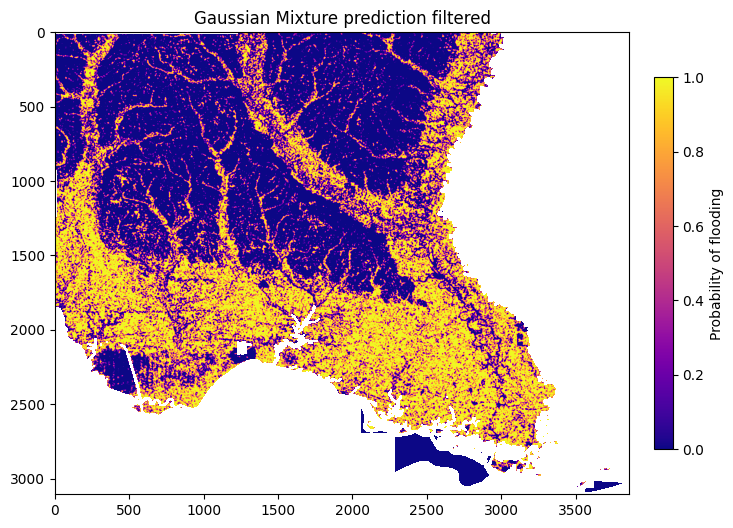

In [21]:
plot_result_map(med_result_map,
                title='Gaussian Mixture prediction filtered',
                #colorbar_label='Probability of flooding',
                #filename=os.path.join(plot_path, 'median_gaussian_map.png'),
                cmap='plasma',
                scatter_df=False)

if satisfied with the result:

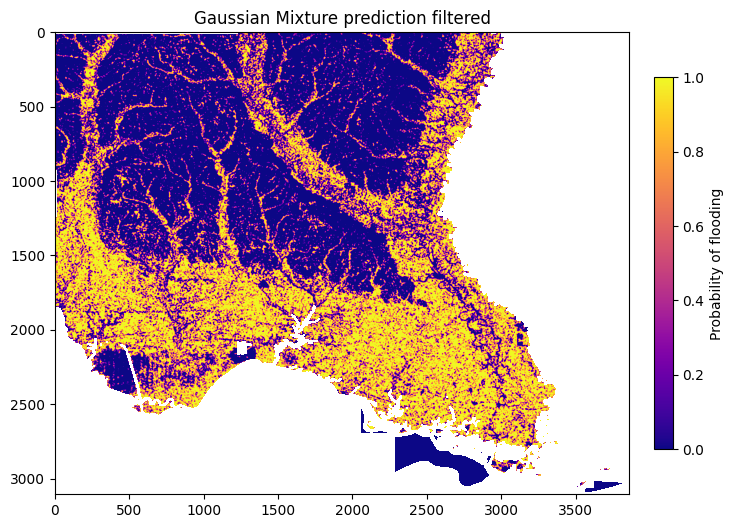

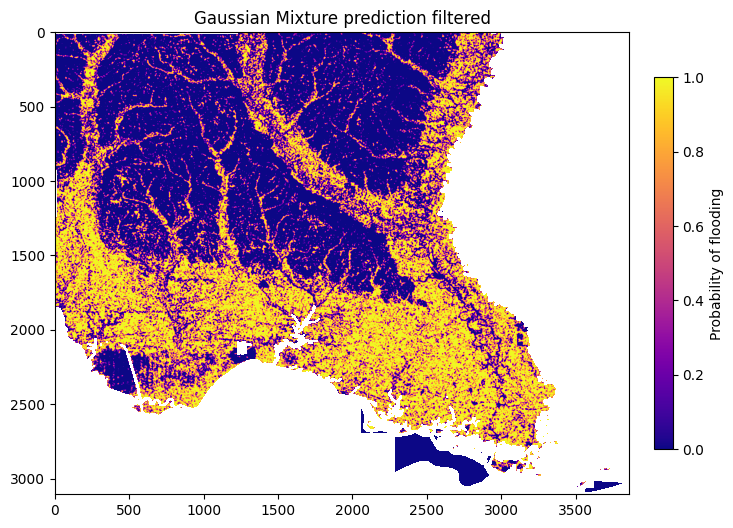

In [39]:
params = [10, 12]


for boost_param in params:

    fn = f"gaussian_mixture_boost_{boost_param}"
    gaussian_map = load_array_from_npy(fn, output_path).astype(bool)

    gaussian_map = medfilt(gaussian_map.astype(float), 9)

    result_maps[fn] = gaussian_map  # replaces the noisy map

    plot_result_map(gaussian_map,
                title='Gaussian Mixture prediction filtered',
                #colorbar_label='Probability of flooding',
                filename=os.path.join(plot_path, 'median_'+fn),
                cmap='plasma',
                scatter_df=False)


## Merge all the output maps (Ensemble learning)

In [40]:
result_maps.keys()

dict_keys(['gaussian_mixture_boost_10', 'gaussian_mixture_boost_12', 'xgboost_boost_2_max_depth_6_scale_pos_weight_100', 'xgboost_boost_4_max_depth_6_scale_pos_weight_100', 'xgboost_boost_4_max_depth_4_scale_pos_weight_100', 'random_forest_boost_8_max_depth_5', 'random_forest_boost_8_max_depth_6'])

In [41]:
def most_frequent(list_arrays):
    return (np.array(list_arrays).mean(axis=0) > 0.5).astype(int)

In [44]:
ensemble_map = most_frequent(list(result_maps.values()))
ensemble_map.shape

(3106, 3862)

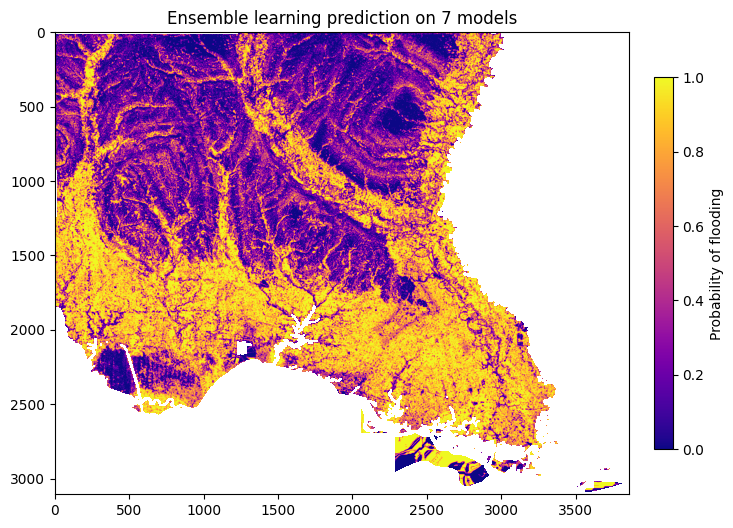

In [45]:
plot_result_map(ensemble_map,
                title=f'Ensemble learning prediction on {len(result_maps)} models',
                colorbar_label='Probability of flooding',
                filename=os.path.join(plot_path, 'final_prediction_map.png'),
                cmap='plasma',
                scatter_df=False)

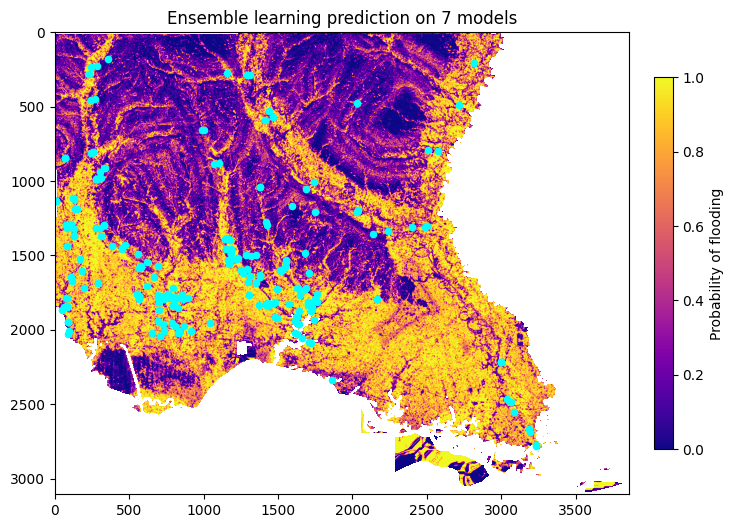

In [38]:
plot_result_map(ensemble_map,
                title=f'Ensemble learning prediction on {len(result_maps)} models',
                colorbar_label='Probability of flooding',
                filename=os.path.join(plot_path, 'final_prediction_map_flood_events.png'),
                cmap='plasma',
                #scatter_df=False,
                color='cyan'
                )


# Fake map

A fake map I came up with to have an idea of what we are aiming for. Turns out it's pretty similar to the previous prediction map!

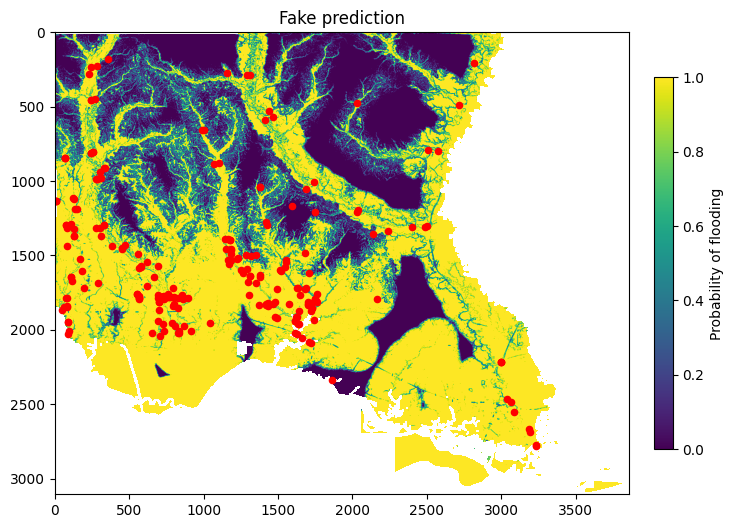

In [ ]:
result_map = load_array_from_npy("fake_map", output_path)

plot_result_map(result_map,
                title='Fake prediction',
                colorbar_label='Probability of flooding',
                #cmap='plasma',
                scatter_df=True)